<a href="https://colab.research.google.com/github/MarcosRMG/Estatisticas-de-Futebol/blob/main/Estatisticas_do_Futebol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Bibliotecas

In [ ]:
#!pip install --upgrade pandas

In [ ]:
#!pip install --upgrade pandas_profiling

In [ ]:
#!pip install category_encoders

In [2]:
# Leitura e tratamento dos dados
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from pandas_profiling import ProfileReport

# Modelos de Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Métodos de extratificação dos dados
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn import tree

# Métricas 
from sklearn import metrics

# Preprocessamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder

# Seleção de parâmetros
from sklearn.model_selection import GridSearchCV

# Pipeline
from sklearn.pipeline import Pipeline

#Outroas
import pickle

In [ ]:
# Personaliza visualizações
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = [16, 8]
sns.set_style(style='darkgrid')

# 2 Funções

## 2.1 Remove variáveis correlacionadas

In [ ]:
def remove_variaveis_correlacionadas(dados: pd.DataFrame):
  '''
  --> Remove as colunas com correlação igual ou maior que 0.95

  :param dados: DataFrame para excluir a coluna com alta correlação
  '''
  alta_corr = .95
  matriz_corr = dados.corr().abs()
  matriz_corr_superior = matriz_corr.where(np.triu(np.ones(matriz_corr.shape).astype(np.bool), k=1))
  excluir = [coluna for coluna in matriz_corr_superior.columns if any(matriz_corr_superior[coluna] > alta_corr)]
  dados.drop(excluir, axis=1, inplace=True)
  print('Variáveis escluídas: ', excluir)

## 2.2 Roda modelo com validação cruzada

In [ ]:
def roda_modelo_cv(dados: pd.DataFrame, y='resultado', 
                x_drop=['clube', 'data', 'rodada', 'oponente', 'resultado'],
                modelo=DecisionTreeRegressor(), n_splits=5, n_repeats=10,
                descricao_modelo='Decision Tree Classifier'):
  '''
  Realiza a validação cruzada

  Keyword arguments
  dados: DataFrame com as informações para treino e teste
  y: Coluna do DataFrame atribuída a variável y
  x_drop: Colunas do DataFrame que devem ser desconsidradas na variável x
  modelo: Modelo para classificação
  n_splits: Número de partes que o DataFrame será divido para validação 
  n_repeats: Número de vezes que o modelo será treinado
  descricao_modelo: Descrição do modelo utilizado

  return: Média do auc de teste e de treino
  '''
  
  np.random.seed(723)
  dados = dados.sample(frac=1).reset_index(drop=True)

  y = dados[y]
  x = dados.drop(x_drop, axis=1)
  ohe = OneHotEncoder(handle_unknown='ignore')
  x = ohe.fit_transform(x)
  scaler = MaxAbsScaler().fit(x)
  x = scaler.transform(x)

  modelo = modelo
  
  cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
  resultado = cross_validate(modelo, x, y, cv=cv, scoring='accuracy', 
                             return_train_score=True)

  media_teste = np.mean(resultado['test_score'])
  media_treino = np.mean(resultado['train_score'])

  print(f'Acurácia teste/ treino: {media_teste:.2f} - {media_treino:.2f}')
  return media_teste, media_treino

## 2.3 Plota curva auc

In [ ]:
def curva_acuracia(media_teste: list(), media_treino: list(), descricao_modelo: str, 
              n_repeats_x=10):
  '''
  Plota o gráfico com o resultado de AUC de treino e teste

  Keyword arguments
  n_repeats_x: Número de repetições do modelo
  media_treino: Resultado médio do AUC de treino
  descricao_modelo: Descrição do modelo utilizado
  '''
  x = range(1, n_repeats_x)
  plt.figure(figsize=(16, 8))
  plt.plot(x, media_teste, label='Acurácia Teste', )
  plt.plot(x, media_treino, label='Acurácia Treino')
  plt.title(descricao_modelo, loc='left', fontsize=24)
  plt.legend();

## 2.4 Personaliza gráfico

In [ ]:
def personaliza_grafico(titulo:str, x_label: str, y_label: str):
  '''
  Define as informações descritivas do gráfico

  Keywords arguments
  titulo: Título do gráfico
  x_label: Descrição do eixo x do gráfico
  y_label: Descrição do eixo y do gráfico
  '''
  plt.title(titulo, loc='left', fontsize=24)
  plt.xlabel(x_label, fontsize=18)
  plt.ylabel(y_label, fontsize=18);

# 3 Dados

In [5]:
fonte_liga_italiana = 'https://raw.githubusercontent.com/MarcosRMG/Estatisticas-de-Futebol/main/dados/italiano/rodadas_liga.csv'
fonte_bundesliga = 'https://raw.githubusercontent.com/MarcosRMG/Estatisticas-de-Futebol/main/dados/bundesliga/rodadas_liga.csv'
fonte_franca = 'https://raw.githubusercontent.com/MarcosRMG/Estatisticas-de-Futebol/main/dados/franca/rodadas_liga.csv'
fonte_la_liga = 'https://raw.githubusercontent.com/MarcosRMG/Estatisticas-de-Futebol/main/dados/la_liga/rodadas_liga.csv'
fonte_premier_league = 'https://raw.githubusercontent.com/MarcosRMG/Estatisticas-de-Futebol/main/dados/premier_league/rodadas_liga.csv'

In [6]:
liga_italiana = pd.read_csv(fonte_liga_italiana).iloc[:, 1:-1]
bundesliga = pd.read_csv(fonte_bundesliga).iloc[:, 1:-1]
franca = pd.read_csv(fonte_franca).iloc[:, 1:-1]
la_liga = pd.read_csv(fonte_la_liga).iloc[:, 1:-1]
premier = pd.read_csv(fonte_premier_league).iloc[:, 1:-1]
todas_ligas = pd.concat([liga_italiana, bundesliga, franca, la_liga, premier])

In [ ]:
todas_ligas.head()

,clube,data,rodada,local,resultado,gols_marcados,gols_sofridos,oponente,posse,gols_partida,escanteios,passes_certos_%,total_chutes,chutes_a_gol_%,chutes_por_gol,cartoes_amarelos,cartoes_vermelhos,faltas_cometidas,cartoes_total,chutes_contra_o_gol,defesas_%,sem_vazamento
0,Inter,2021-03-14,27,Visitante,V,2.0,1.0,Torino,68.0,3.0,8.0,87.7,12,16.7,6.0,1,0,12,1,3,66.7,0
1,Inter,2021-03-08,26,Em casa,V,1.0,0.0,Atalanta,45.0,1.0,7.0,80.4,5,20.0,5.0,0,0,17,0,2,100.0,1
2,Inter,2021-03-04,25,Visitante,V,2.0,1.0,Parma,48.0,3.0,2.0,86.1,12,50.0,6.0,1,0,11,1,2,50.0,0
3,Inter,2021-02-28,24,Em casa,V,3.0,0.0,Genoa,51.0,3.0,9.0,87.4,24,50.0,8.0,0,0,13,0,2,100.0,1
4,Inter,2021-02-21,23,Visitante,V,3.0,0.0,Milan,40.0,3.0,7.0,81.1,15,40.0,5.0,1,0,10,1,8,100.0,1


In [ ]:
todas_ligas.shape

(2681, 22)

In [ ]:
todas_ligas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2681 entries, 0 to 572
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   clube                2681 non-null   object 
 1   data                 2681 non-null   object 
 2   rodada               2681 non-null   int64  
 3   local                2681 non-null   object 
 4   resultado            2681 non-null   object 
 5   gols_marcados        2681 non-null   float64
 6   gols_sofridos        2681 non-null   float64
 7   oponente             2681 non-null   object 
 8   posse                2681 non-null   float64
 9   gols_partida         2681 non-null   float64
 10  escanteios           2681 non-null   float64
 11  passes_certos_%      2681 non-null   float64
 12  total_chutes         2681 non-null   int64  
 13  chutes_a_gol_%       2681 non-null   float64
 14  chutes_por_gol       2681 non-null   float64
 15  cartoes_amarelos     2681 non-null   in

In [ ]:
# Os valores NaN em defesas_% ocorrem quando não houve chute ao gol
todas_ligas.isna().sum()

clube                   0
data                    0
rodada                  0
local                   0
resultado               0
gols_marcados           0
gols_sofridos           0
oponente                0
posse                   0
gols_partida            0
escanteios              0
passes_certos_%         0
total_chutes            0
chutes_a_gol_%          0
chutes_por_gol          0
cartoes_amarelos        0
cartoes_vermelhos       0
faltas_cometidas        0
cartoes_total           0
chutes_contra_o_gol     0
defesas_%              96
sem_vazamento           0
dtype: int64

In [9]:
# O preenchimento de 100 considera que o sistema defensivo funcionou mesmo não 
# havendo chute pelo adversário
todas_ligas.fillna(100, inplace=True)

# 4 Análise Exploratória

In [ ]:
todas_ligas.describe().round(2)

,rodada,gols_marcados,gols_sofridos,posse,gols_partida,escanteios,passes_certos_%,total_chutes,chutes_a_gol_%,chutes_por_gol,cartoes_amarelos,cartoes_vermelhos,faltas_cometidas,cartoes_total,chutes_contra_o_gol,defesas_%,sem_vazamento
count,2681.00,2681.00,2681.00,2681.00,2681.00,2681.00,2681.00,2681.00,2681.00,2681.00,2681.00,2681.00,2681.00,2681.00,2681.00,2681.00,2681.00
mean,14.28,1.38,1.37,50.02,2.75,4.73,78.60,11.55,34.31,5.93,1.97,0.09,14.35,2.05,3.90,69.24,0.27
std,8.01,1.23,1.23,11.31,1.66,2.80,6.86,4.99,16.44,5.42,1.32,0.30,4.16,1.41,2.33,29.05,0.44
min,1.00,0.00,0.00,18.00,0.00,0.00,48.80,1.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,-100.00,0.00
25%,7.00,0.00,0.00,42.00,2.00,3.00,74.50,8.00,23.10,0.00,1.00,0.00,11.00,1.00,2.00,50.00,0.00
50%,14.00,1.00,1.00,50.00,3.00,4.00,79.70,11.00,33.30,5.00,2.00,0.00,14.00,2.00,4.00,75.00,0.00
75%,21.00,2.00,2.00,58.00,4.00,6.00,83.60,14.00,44.40,9.00,3.00,0.00,17.00,3.00,5.00,100.00,1.00
max,33.00,9.00,9.00,82.00,9.00,19.00,92.90,33.00,100.00,33.00,8.00,3.00,31.00,10.00,14.00,100.00,2.00


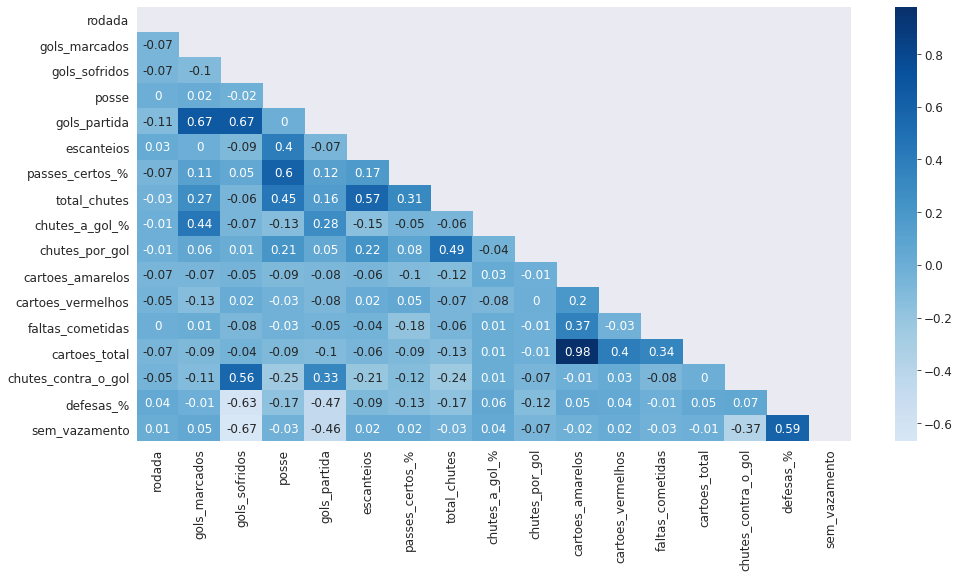

In [ ]:
mask = np.zeros_like(liga_italiana.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(16, 8))
sns.heatmap(liga_italiana.corr().round(2), cmap='Blues', annot=True, mask=mask,
            center=0);

In [ ]:
#profile = ProfileReport(liga_italiana, title='Pandas Profiling Report',
#                        explorative=True, html={'style': {'full_width': True}})

In [ ]:
#profile.to_file('analise_exploratoria_liga_italiana.html')

# 5 Modelos

In [ ]:
remove_variaveis_correlacionadas(todas_ligas)

Variáveis escluídas:  ['cartoes_total']


In [ ]:
pipeline_1 = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                       ('normalizacao', MaxAbsScaler()),
                       ('modelo', RandomForestClassifier())
])

In [ ]:
# Features e labels
x = liga_italiana.drop(['clube', 'data', 'rodada', 'oponente', 'gols_partida',
                        'gols_marcados'],
                       axis=1)
y = liga_italiana['gols_marcados']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_1.fit(x_treino, y_treino)

Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(categories='auto', drop=None,
                               dtype=<class 'numpy.float64'>,
                               handle_unknown='ignore', sparse=True)),
                ('normalizacao', MaxAbsScaler(copy=True)),
                ('modelo',
                 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                       max_depth=None, max_features=None,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort='deprecated', random_state=None,
                                       splitter='best'))],
         verbose=False)

In [ ]:
previsao = pipeline_1.predict(x_teste)
pipeline_1.score(x_teste, y_teste)

0.4829326209557732



---



## 5.1 Resultado da partida

In [7]:
pipeline_resultado = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                               ('normalizacao', MaxAbsScaler()),
                               ('modelo', DecisionTreeClassifier())
])

In [ ]:
pipeline_resultado_2 = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                               ('normalizacao', MaxAbsScaler()),
                               ('modelo', LogisticRegression())
])

In [ ]:
pipeline_resultado_3 = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                               ('normalizacao', MaxAbsScaler()),
                               ('modelo', RandomForestClassifier())
])

In [ ]:
pipeline_resultado_4 = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                               ('normalizacao', MaxAbsScaler()),
                               ('modelo', SVC())
])



---



In [10]:
x = todas_ligas.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = todas_ligas['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado.fit(x_treino, y_treino)
previsao = pipeline_resultado.predict(x_teste)
print('Resultado da Partida - Decision Tree')
print(f'Acurácia treino: {pipeline_resultado.score(x_teste, y_teste):.2f}')

Resultado da Partida - Decision Tree
Acurácia treino: 1.00


In [11]:
#output = open('resultado_partida_random_forest', 'wb')
#pickle.dump(pipeline_resultado, output)

In [12]:
x.columns

Index(['local', 'gols_marcados', 'gols_sofridos', 'posse', 'gols_partida',
       'escanteios', 'passes_certos_%', 'total_chutes', 'chutes_a_gol_%',
       'chutes_por_gol', 'cartoes_amarelos', 'cartoes_vermelhos',
       'faltas_cometidas', 'cartoes_total', 'chutes_contra_o_gol', 'defesas_%',
       'sem_vazamento'],
      dtype='object')

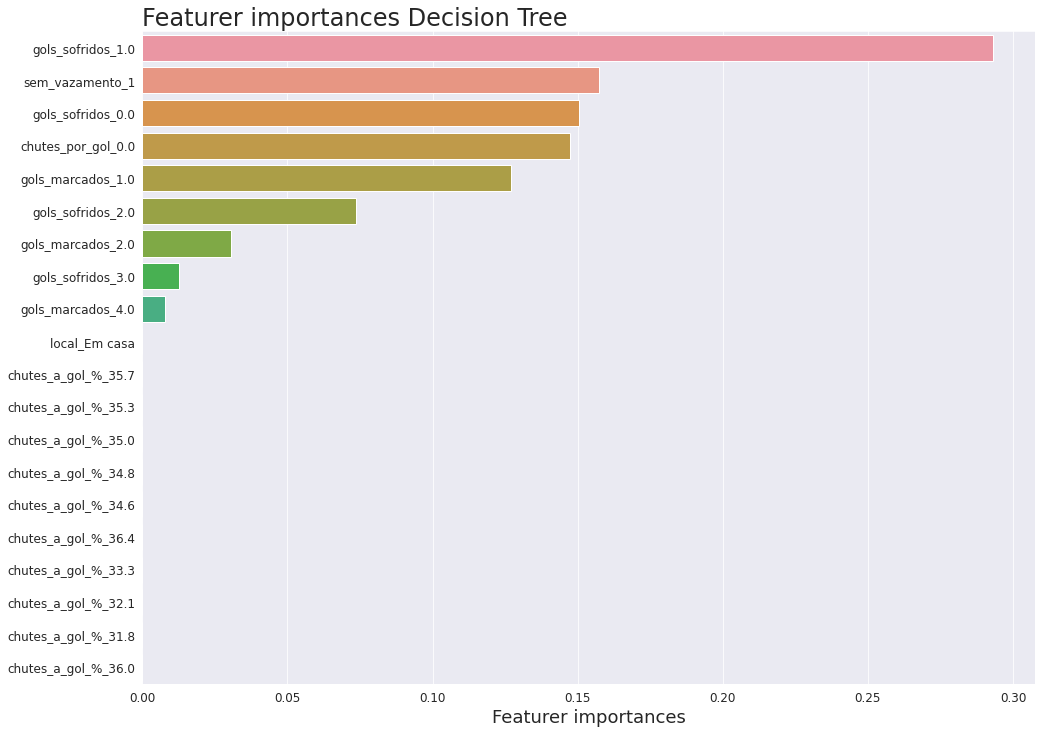

In [ ]:
_ = pd.DataFrame({'feature_importance': pipeline_resultado['modelo'].feature_importances_,
                  'variavel': pipeline_resultado['ohe'].get_feature_names(x_treino.columns)}).sort_values('feature_importance', 
                                                                                          ascending=False)
plt.figure(figsize=(16, 12))
sns.barplot(data=_[:20], y='variavel', x='feature_importance', orient='h')
personaliza_grafico('Featurer importances Decision Tree', 
                    'Featurer importances', '')

In [ ]:
pipeline_resultado['ohe'].get_feature_names()

In [ ]:
pipeline_resultado['modelo'].feature_importances_

In [ ]:
x = todas_ligas.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = todas_ligas['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado_2.fit(x_treino, y_treino)
previsao = pipeline_resultado_2.predict(x_teste)
print('Resultado da Partida')
print('Logistic Regression')
print(f'Acurácia: {pipeline_resultado_2.score(x_teste, y_teste):.2f}')

Resultado da Partida
Logistic Regression
Acurácia: 0.99


In [ ]:
x = todas_ligas.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = todas_ligas['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado_3.fit(x_treino, y_treino)
previsao = pipeline_resultado_3.predict(x_teste)
print('Resultado da Partida - Random Forest')
print(f'Acurácia: {pipeline_resultado_3.score(x_teste, y_teste):.2f}')

Resultado da Partida - Random Forest
Acurácia: 1.00


In [ ]:
x = todas_ligas.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = todas_ligas['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado_4.fit(x_treino, y_treino)
previsao = pipeline_resultado_4.predict(x_teste)
print('Resultado da Partida - SVC')
print(f'Acurácia: {pipeline_resultado_4.score(x_teste, y_teste):.2f}')

Resultado da Partida - SVC
Acurácia: 1.00




---



In [ ]:
roda_modelo_cv(todas_ligas, modelo=RandomForestClassifier(), 
               descricao_modelo='Random Forest Classifier')

Acurácia teste/ treino: 1.00 - 1.00


(1.0, 0.9986572028127517)

In [ ]:
acuracia_teste = list()
acuracia_treino = list()
for i in range(1, 10):
  teste, treino = roda_modelo_cv(todas_ligas, modelo=DecisionTreeClassifier(max_depth=i), 
                 descricao_modelo='Decision Tree Classifier')
  acuracia_teste.append(teste)
  acuracia_treino.append(treino)

Acurácia teste/ treino: 0.56 - 0.57
Acurácia teste/ treino: 0.66 - 0.66
Acurácia teste/ treino: 0.76 - 0.77
Acurácia teste/ treino: 0.90 - 0.90
Acurácia teste/ treino: 0.93 - 0.93
Acurácia teste/ treino: 0.95 - 0.95
Acurácia teste/ treino: 0.98 - 0.98
Acurácia teste/ treino: 0.99 - 0.99
Acurácia teste/ treino: 0.99 - 0.99


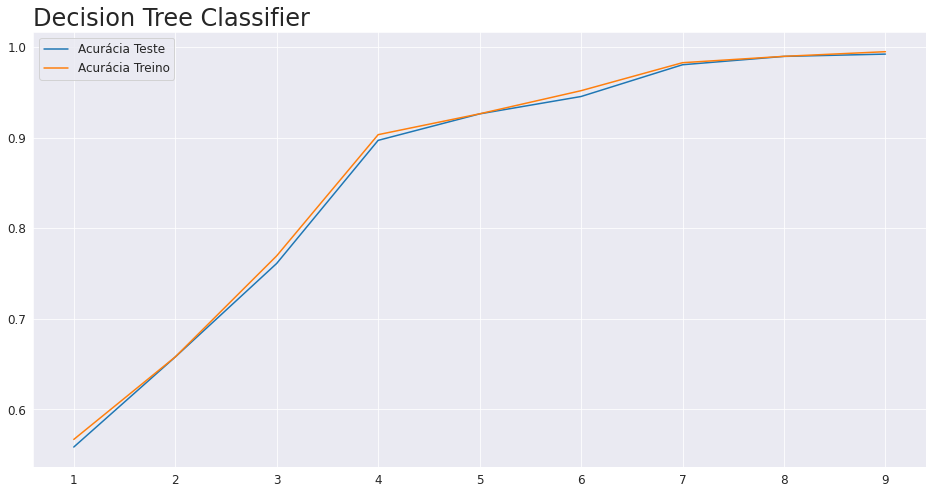

In [ ]:
curva_acuracia(acuracia_teste, acuracia_treino, 'Decision Tree Classifier')

# Referências

FBREF. Estatísticas e Histórico do Futebol. Disponível em: https://fbref.com/pt/. Acesso em:  24 Fev. 2021.



---

